In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from lxml import objectify
import xml.etree.ElementTree as ET
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import re
import pycats


In [7]:
tree = ET.parse('Library.xml')
root = tree.getroot()
root

<Element 'plist' at 0x150a4af40>

In [8]:
main_dict=root.findall('dict')

for index, item in enumerate(list(main_dict[0])):  
    print('index #{} = <{}>'.format(index, item.tag))
    if item.tag=="dict":
        print('The tracks dict has been found!')
        tracks_dict=item
        break


index #0 = <key>
index #1 = <integer>
index #2 = <key>
index #3 = <integer>
index #4 = <key>
index #5 = <date>
index #6 = <key>
index #7 = <string>
index #8 = <key>
index #9 = <integer>
index #10 = <key>
index #11 = <true>
index #12 = <key>
index #13 = <string>
index #14 = <key>
index #15 = <string>
index #16 = <key>
index #17 = <dict>
The tracks dict has been found!


In [9]:
tracklist = list(tracks_dict.findall('dict'))
len(tracklist)

6539

In [10]:
kinds = set([])
for i in range(len(tracklist)):
    for j in range(len(tracklist[i])):
        if (tracklist[i][j].tag == 'key' and tracklist[i][j].text== 'Kind'):
            kinds.add(tracklist[i][j+1].text)

kinds = pd.Series(list(kinds))
kinds

0                AAC audio file
1               MPEG audio file
2    Apple Music AAC audio file
3      Purchased AAC audio file
4             MPEG-4 video file
dtype: object

In [11]:
valid_datatypes = pd.Series([
    'AAC audio file',
    'MPEG audio file',
    'MPEG audio file',
    'Apple Music AAC audio file'
])

In [12]:
# This code will retrieve all the 'keys' (attributes) of the first track of the corresponding Kind
def cols(kind):
    cols = []
    kind_found = False
    for i in range(len(tracklist)):
        for j in range(len(tracklist[i])):
            if tracklist[i][j].tag == "key":
                cols.append(tracklist[i][j].text)
            if (j < len(tracklist[i]) - 1 and tracklist[i][j].text == "Kind" and tracklist[i][j + 1].text == kind):
                kind_found = True
                break  # Once the kind is found, break the inner loop
        if kind_found:
            return set(cols)  # Return the set of columns if kind is found

# Sample usage
cols('AAC audio file')


{'Album',
 'Album Artist',
 'Album Loved',
 'Apple Music',
 'Artist',
 'Artwork Count',
 'Bit Rate',
 'Clean',
 'Compilation',
 'Composer',
 'Date Added',
 'Date Modified',
 'Disc Count',
 'Disc Number',
 'Explicit',
 'Favorited',
 'Genre',
 'Kind',
 'Loved',
 'Name',
 'Normalization',
 'Part Of Gapless Album',
 'Persistent ID',
 'Play Count',
 'Play Date',
 'Play Date UTC',
 'Playlist Only',
 'Purchased',
 'Release Date',
 'Sample Rate',
 'Size',
 'Skip Count',
 'Skip Date',
 'Sort Album',
 'Sort Album Artist',
 'Sort Artist',
 'Sort Composer',
 'Sort Name',
 'Total Time',
 'Track Count',
 'Track ID',
 'Track Number',
 'Track Type',
 'Year'}

In [13]:
results = map(cols, valid_datatypes)
results_list = [list(item) for item in results]
results_list

[['Sort Composer',
  'Normalization',
  'Total Time',
  'Bit Rate',
  'Kind',
  'Sort Artist',
  'Track Type',
  'Track Number',
  'Name',
  'Favorited',
  'Play Date',
  'Artist',
  'Skip Date',
  'Sort Album',
  'Genre',
  'Persistent ID',
  'Playlist Only',
  'Composer',
  'Track Count',
  'Sort Name',
  'Track ID',
  'Date Added',
  'Disc Count',
  'Sort Album Artist',
  'Part Of Gapless Album',
  'Year',
  'Release Date',
  'Disc Number',
  'Compilation',
  'Apple Music',
  'Explicit',
  'Play Date UTC',
  'Album Artist',
  'Play Count',
  'Date Modified',
  'Artwork Count',
  'Album Loved',
  'Size',
  'Loved',
  'Clean',
  'Purchased',
  'Album',
  'Skip Count',
  'Sample Rate'],
 ['Sort Composer',
  'Normalization',
  'Total Time',
  'Bit Rate',
  'Kind',
  'Sort Artist',
  'Track Type',
  'Track Number',
  'Name',
  'Favorited',
  'Play Date',
  'Artist',
  'Skip Date',
  'Sort Album',
  'Genre',
  'Persistent ID',
  'Playlist Only',
  'Composer',
  'Track Count',
  'Sort Name

In [14]:
flat_list=[]

for item in results_list:
  for sub_item in item:
    flat_list.append(sub_item)

unique_cols = set(flat_list) # set funcation gives unique items list

print(unique_cols)



{'Normalization', 'Sort Composer', 'Total Time', 'Kind', 'Sort Artist', 'Track Type', 'Track Number', 'Name', 'Favorited', 'Play Date', 'Artist', 'Skip Date', 'Sort Album', 'Genre', 'Persistent ID', 'Playlist Only', 'Track Count', 'Composer', 'Sort Name', 'Disliked', 'Track ID', 'Date Added', 'Disc Count', 'Grouping', 'Sort Album Artist', 'Part Of Gapless Album', 'Year', 'Release Date', 'Disc Number', 'Compilation', 'Apple Music', 'Sample Rate', 'Explicit', 'Play Date UTC', 'Album Artist', 'Play Count', 'Date Modified', 'Artwork Count', 'Album Loved', 'Size', 'Loved', 'Matched', 'Clean', 'Purchased', 'Album', 'Skip Count', 'Bit Rate'}


In [15]:
len(unique_cols) # superset of all common unique entries between all the filetypes

47

In [16]:
unique_cols_list = list(unique_cols)

df_tracks=pd.DataFrame(columns=unique_cols_list)

dict1={}

for song_i in range(len(tracklist)):
  for attribute_i in range(len(tracklist[song_i])):
    if tracklist[song_i][attribute_i].tag=="key":
      dict1[tracklist[song_i][attribute_i].text]=tracklist[song_i][attribute_i+1].text
  list_values=[i for i in dict1.values()]
  list_keys=[j for j in dict1.keys()]
  if dict1['Kind'] in valid_datatypes.unique():
    df_temp=pd.DataFrame([list_values],columns=list_keys)
    df_tracks=pd.concat([df_tracks,df_temp],axis=0,ignore_index=True,sort=True)

In [17]:
df_tracks[['Play Count']] = df_tracks[['Play Count']].apply(pd.to_numeric)

In [18]:
top_songs=(df_tracks.sort_values(by='Play Count', ascending=False)[['Name', 'Artist', 'Play Count', 'Genre']])

top_songs

,Name,Artist,Play Count,Genre
4548,Save Your Tears (Remix),The Weeknd & Ariana Grande,112.0,R&B/Soul
4850,Self Love (Spider-Man: Across the Spider-Verse),Metro Boomin & Coi Leray,98.0,Hip-Hop/Rap
4503,"Wish On An Eyelash, Pt. 2",Mallrat & The Chainsmokers,83.0,Alternative
4469,Eyes Wide Shut,"ILLENIUM, Avril Lavigne & Travis Barker",78.0,Dance
4806,Electric Touch (Taylor's Ve rsion) (From The V...,Taylor Swift,70.0,Pop
...,...,...,...,...
123,Words Can't Describe,Flourish & Jack Howard,NaN,Pop
124,The Stranger,Ingrid Andress,NaN,Country
125,Chemical,Post Malone,NaN,Pop
126,Gangsta's Paradise (feat. L.V.),Coolio,NaN,Hip-Hop/Rap


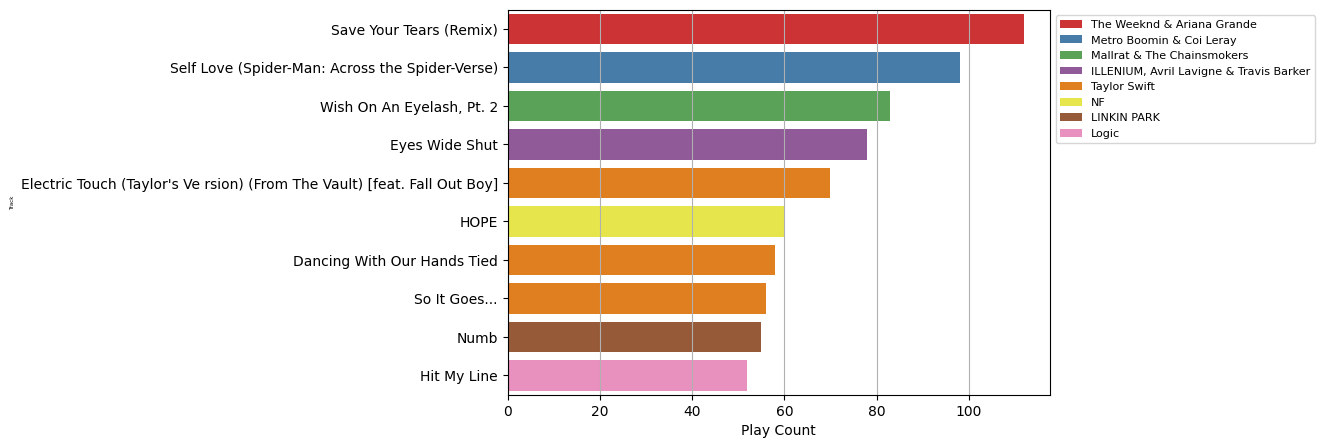

In [19]:
plt.clf()
ax=sns.barplot(x='Play Count',
            y='Name',
            hue='Artist',
            data=top_songs.head(10),
            dodge=False,
            palette=sns.color_palette("Set1"))
ax.figure.set_size_inches(7,5)
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.grid(True)
ax.set_ylabel('Track', fontsize=4)
#plt.savefig('test.png', dpi=400)
plt.show()

In [20]:
ntracks_album=df_tracks.groupby('Album').size()
full_albums=(ntracks_album[ntracks_album>5]
             .reset_index()
             .rename(columns={0: "n_tracks"}))
full_albums

,Album,n_tracks
0,#3,9
1,(What's the Story) Morning Glory? [Deluxe Edit...,9
2,1989 (Taylor's Version),21
3,=,14
4,A Head Full Of Dreams,9
...,...,...
146,misery lake - EP,6
147,no future,19
148,reputation,7
149,vertigo,13


In [21]:
plays_by_album=(df_tracks
                .groupby('Album')['Play Count']
                .sum()
                .reset_index()
                .sort_values(by='Play Count', ascending=False))

full_albums_ranked=plays_by_album[plays_by_album.Album.isin(full_albums.Album)]
full_albums_ranked.head(10)

,Album,Play Count
1580,ILLENIUM,311.0
1951,METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE S...,294.0
3852,reputation,277.0
1071,Fallen Embers (Deluxe Version),204.0
677,Clancy,189.0
2834,Speak Now (Taylor's Version),189.0
516,Blurryface,156.0
3833,mainstream sellout (life in pink deluxe),132.0
2650,Scaled And Icy (Livestream Version),130.0
1556,I met you when I was 18. (the playlist),127.0


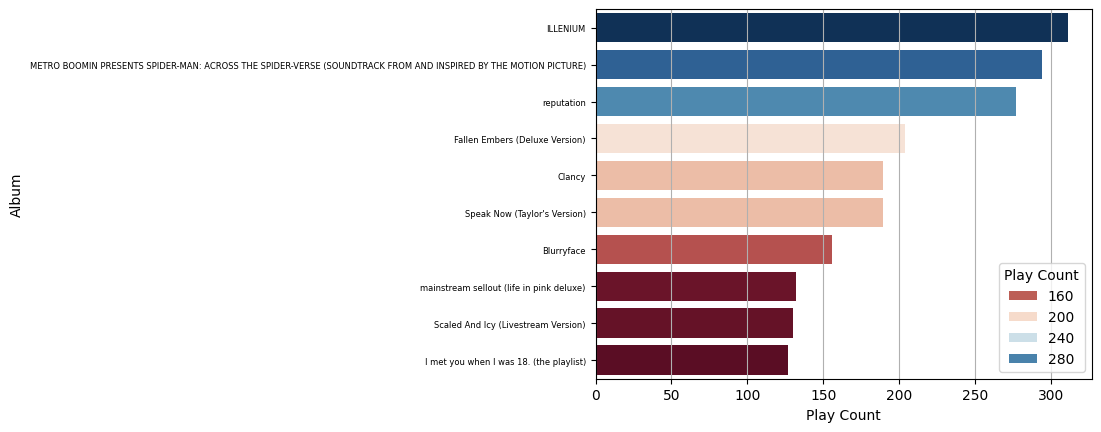

In [22]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Album',
               hue='Play Count',
              data=full_albums_ranked.head(10),
              dodge='auto',
              palette='RdBu')
ax.tick_params(axis='y', labelsize=6)
ax.xaxis.grid(True)
plt.show()

In [23]:
delimiters=' & ',', ',' Feat. ',' feat. ','/', ' feat ', 'Feat'
regexPattern = '|'.join(map(re.escape, delimiters))
reg_split=re.compile(regexPattern)
artists_splitted=df_tracks.Artist.str.split(regexPattern)
artists_splitted

0                        [Nirvana]
1                  [Fleetwood Mac]
2                    [Michigander]
3                  [You Me At Six]
4                   [Zara Larsson]
                   ...            
6514                     [Decadon]
6515    [Bachman-Turner Overdrive]
6516           [Christian Löffler]
6517                   [Meg Smith]
6518                        [Muse]
Name: Artist, Length: 6519, dtype: object

In [24]:
songs=[]
for i, song in df_tracks.Name.items():
  ## Parse the artists of the song
  if df_tracks.Artist.values[i]=='Now, Now':
    artist_to_assign=[df_tracks.Artist.values[i]]
  if df_tracks.Artist.values[i]=='AC/DC':
    artist_to_assign=[df_tracks.Artist.values[i]]
  else:
    artist_to_assign=artists_splitted.values[i]

  ## add elements to the list of songs
  songs.append({'Name': song,
                'Number': i,
                'Artists': artist_to_assign})

songs[:5]

[{'Name': 'About a Girl (Live Acoustic)', 'Number': 0, 'Artists': ['Nirvana']},
 {'Name': 'Go Your Own Way', 'Number': 1, 'Artists': ['Fleetwood Mac']},
 {'Name': 'Cannonball', 'Number': 2, 'Artists': ['Michigander']},
 {'Name': 'SUCKAPUNCH', 'Number': 3, 'Artists': ['You Me At Six']},
 {'Name': "Can't Tame Her", 'Number': 4, 'Artists': ['Zara Larsson']}]

In [25]:
# One regex for each pattern variation: round brackets, squared brackets, and no brackets
# Note how in the variations with brackets we have to look for the closing bracket, while in the "bare" variation we just extract everthying from "feat." to the end of the string
re_circ_brackets=re.compile(' \(feat\.* (.*)\)')
re_sq_brackets=re.compile(' \[feat. ([^\[]*)\]')
re_bare=re.compile(' feat. (.*)$')

# Creating bolean arrays based on which of the pattern variations is present in the song name (note that it could be none)
feat_curved_brackets=df_tracks.Name.str.contains('\(feat.').values
feat_squared_brackets=df_tracks.Name.str.contains('\[feat.').values
feat_bare=df_tracks.Name.str.contains(' feat.').values

In [26]:
df_tracks_clean = df_tracks.dropna(subset=['Play Count'])

df_tracks_clean['Play Count'].dtype

dtype('float64')

In [27]:
import re

for i, song in df_tracks_clean['Name'].items():
    artists_feat = ''  # Initialize artists_feat variable
    if feat_curved_brackets[i]:
        artists_feat = re.search(r'\((.*?)\)', song).group(1)
    elif feat_squared_brackets[i]:
        artists_feat = re.search(r'\[(.*?)\]', song).group(1)
    elif feat_bare[i]:
        try:
            artists_feat = re.search(r'\{(.*?)\}', song).group(1)
        except AttributeError:
            pass  # Handle the case when no match is found

    if artists_feat:  # Check if artists_feat is not an empty string
        splitted_artists_feat = re.split(r',\s*', artists_feat)
        songs[i]['Artists'].extend(splitted_artists_feat)

In [28]:
for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    artist_name=songs[i]['Artists'][j]
    norm_artist_name=artist_name.title().replace('.', '')
    songs[i]['Artists'][j]=norm_artist_name


In [29]:
artists={}

for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    if songs[i]['Artists'][j] not in artists:
      artists[songs[i]['Artists'][j]]=df_tracks['Play Count'][i]
    else:
      artists[songs[i]['Artists'][j]]+=df_tracks['Play Count'][i]

df_artists_plays=pd.DataFrame(artists.items(),
                              columns=['Artist', 'Play Count'])

df_artists_plays = df_artists_plays.dropna()

df_artists_plays.head(5)

,Artist,Play Count
122,Lauv,348.0
123,Feat Travis Mills,3.0
124,The Local Train,87.0
125,Kygo,151.0
126,Feat Dnce,43.0


In [30]:
df_artists_plot=(df_artists_plays
                 .sort_values(by='Play Count', ascending=False)
                 .head(10))

df_artists_plot

,Artist,Play Count
444,Taylor Swift,1088.0
128,Illenium,910.0
130,Twenty One Pilots,786.0
168,Linkin Park,594.0
464,Onerepublic,383.0
159,Logic,364.0
146,Eminem,354.0
122,Lauv,348.0
217,Mgk,347.0
416,Coldplay,326.0


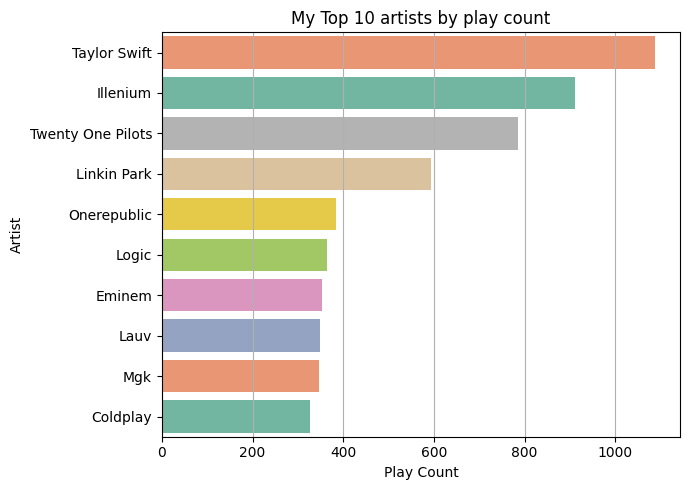

In [31]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Artist',
               hue='Play Count',
              data=df_artists_plot,
              dodge=False,
              palette='Set2')

# Rotating labels trying to make them fit
ax.figure.set_size_inches(7,5)
ax.xaxis.grid(True)
plt.title('My Top 10 artists by play count')
plt.tight_layout()
plt.legend([],[], frameon=False)
plt.show()

In [32]:
df_tracks[['Year']]=df_tracks[['Year']].apply(pd.to_numeric)

df_tracks=(df_tracks.assign(FiveYearPeriod=pd.to_numeric(np.floor(df_tracks.Year / 5) * 5, downcast='integer')))

In [33]:
df_tracks.groupby("FiveYearPeriod").size()


FiveYearPeriod
1900       1
1945       1
1950       1
1955       5
1960       6
1965      60
1970     103
1975     125
1980     144
1985     121
1990     130
1995     160
2000     427
2005     538
2010    1194
2015    1453
2020    2050
dtype: int64

In [34]:
catg_years=pd.Categorical(df_tracks.FiveYearPeriod,
               ordered=True,
               categories=['Before 1995', 1995, 2000, 2005, 2010, 2015, 2020])

df_tracks.FiveYearPeriod=catg_years.rename_categories({1995: '1995-1999', 2000: '2000-2004', 2005: '2005-2009', 2010: '2010-2014', 2015: '2015-2019', 2020: '2020-Present'})

In [35]:
songs_period=df_tracks.groupby(['FiveYearPeriod']).size()
songs_period = songs_period.fillna(0)
songs_period

FiveYearPeriod
Before 1995        0
1995-1999        160
2000-2004        427
2005-2009        538
2010-2014       1194
2015-2019       1453
2020-Present    2050
dtype: int64

In [36]:
plays_period=df_tracks.groupby(['FiveYearPeriod'])['Play Count'].mean()
plays_period = plays_period.fillna(0)
plays_period

FiveYearPeriod
Before 1995     0.000000
1995-1999       6.230769
2000-2004       4.983412
2005-2009       5.423150
2010-2014       3.930567
2015-2019       5.173278
2020-Present    6.946500
Name: Play Count, dtype: float64

<Figure size 640x480 with 0 Axes>

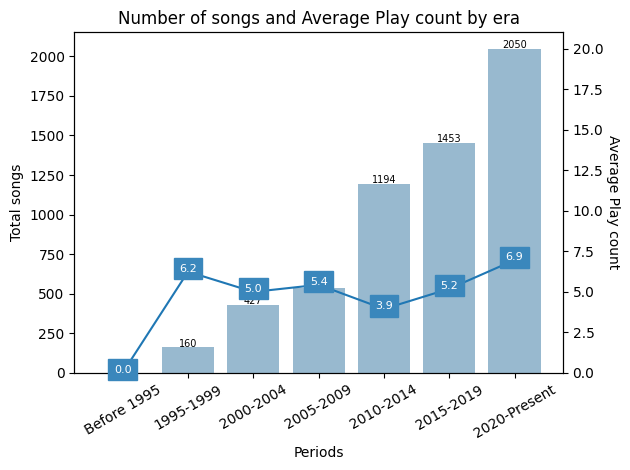

In [37]:
plt.clf()
fig, ax1 = plt.subplots()
sns1=sns.barplot(x=songs_period.index, y=songs_period.values, alpha=0.5)

# Adding labels to bar plot
for a, b in zip(songs_period.index, songs_period.values):
  plt.text(x = a, y = b+5, s = '{:.0f}'.format(b), size=7, color='black', ha='center')


ax2 = ax1.twinx()
sns2=sns.lineplot(x=plays_period.index, y=plays_period.values, marker='o')
sns2.set_ylim(0, 21)

sns1.set(xlabel='Periods', ylabel='Total songs')
sns2.set_ylabel('Average Play count', rotation=270, labelpad=12.0)
sns1.set_xticklabels(sns1.get_xticklabels(),rotation = 30)

# Adding labels to line plot
for x, y in zip(plays_period.index, plays_period.values):
  plt.text(x = x, y = y, s = '{:.1f}'.format(y), size=8, color='white', ha='center').set_backgroundcolor('#3A87BC')

sns1.set(title='Number of songs and Average Play count by era')
plt.tight_layout()
plt.savefig('fig_twop_plots.png')
plt.show()

In [38]:
df_tracks['Genres_lumped']=pycats.cat_lump(pycats.as_cat(df_tracks['Genre']), 4)
df_tracks['Genres_lumped'].value_counts()

Genres_lumped
Other          1905
Pop            1853
Alternative    1438
Rock            959
Dance           364
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

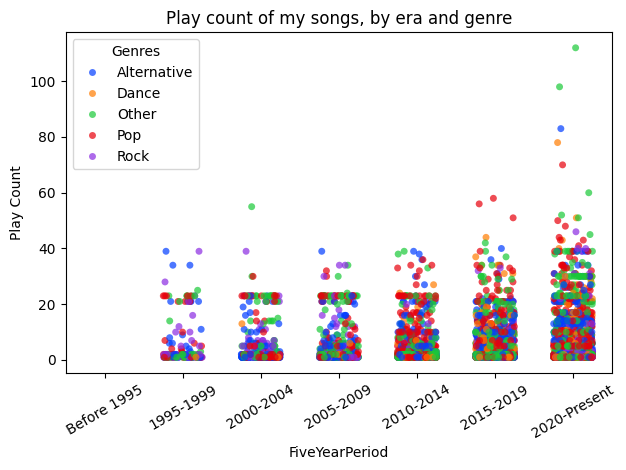

In [39]:
plt.clf()
plt.figure()

# Draw a categorical scatterplot to show each observation
ax = sns.stripplot(data=df_tracks, y="Play Count", x="FiveYearPeriod", hue="Genres_lumped", size=5, alpha=0.7, jitter=0.25, palette='bright')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.legend(title='Genres')
plt.title('Play count of my songs, by era and genre')
plt.tight_layout()
plt.show()

In [47]:
def top_songs(df, n=3, column='Play Count'):
  return df.sort_values(by=column, ascending=False)[:n]


top_songs_per_era=(df_tracks
                   .groupby('FiveYearPeriod')
                   .apply(top_songs)
                   [['Album', 'Artist', 'Name', 'Play Count', 'FiveYearPeriod', 'Genres_lumped']])

In [49]:
# Reset index to avoid ambiguity
top_songs_per_era.reset_index(drop=True, inplace=True)

# Select columns and rename them
df = top_songs_per_era.rename(columns={
    'FiveYearPeriod': 'FiveYearPeriod',
    'Name': 'Song',
    'Album': 'Album',
    'Artist': 'Artist',
    'Play Count': 'Play Count',
    'Genres_lumped': 'Genre'
})

# Group by FiveYearPeriod and add row number
df['row_n'] = df.groupby('FiveYearPeriod').cumcount() + 1

# Add Era column based on row number
df['Era'] = df.apply(lambda row: '' if row['row_n'] > 1 else str(row['FiveYearPeriod']), axis=1)

# Hide Era column
df = df.drop(columns=['row_n', 'Era'])

# Style cells
def style_cells(row):
    if row['Genre'] == 'Alternative':
        return ['background-color: #fff7e5'] * len(row)
    elif row['Genre'] == 'Pop':
        return ['background-color: #ebf0fa'] * len(row)
    elif row['Genre'] == 'Rock':
        return ['background-color: #faebeb'] * len(row)
    elif row['Genre'] == 'Urbano latino':
        return ['background-color: #f5edf7'] * len(row)
    elif row['Genre'] == 'Other':
        return ['background-color: #f2f2f2'] * len(row)
    else:
        return [''] * len(row)

styled_df = df.style.apply(style_cells, axis=1)
styled_df.set_properties(**{'background-color': 'transparent'})


# Set table header, source note, header, footnote
styled_df.set_caption("My favourite songs across different eras")
styled_df.set_table_styles([{
    'selector': 'caption',
    'props': [('font-weight', 'bold')]
}])
styled_df.set_caption("My favourite songs across different eras")
styled_df.set_caption("(This would be a nice playlist imho)")

# Print styled DataFrame
styled_df

,Album,Artist,Song,Play Count,FiveYearPeriod,Genre
0,311,311,Down,39.000000,1995-1999,Rock
1,Prolonging the Magic (Deluxe Version),CAKE,Never There,39.000000,1995-1999,Alternative
2,Third Eye Blind,Third Eye Blind,Semi-Charmed Life,34.000000,1995-1999,Alternative
3,Meteora (Deluxe Edition),LINKIN PARK,Numb,55.000000,2000-2004,Other
4,Absolution,Muse,Hysteria,39.000000,2000-2004,Rock
5,Nellyville (Deluxe Edition),Nelly,Dilemma (feat. Kelly Rowland),30.000000,2000-2004,Pop
6,Cage the Elephant (Expanded Edition),Cage the Elephant,Ain't No Rest for the Wicked,39.000000,2005-2009,Alternative
7,Broken Boy Soldiers,The Raconteurs,"Steady, As She Goes",34.000000,2005-2009,Rock
8,Sam's Town,The Killers,When You Were Young,34.000000,2005-2009,Rock
9,El Camino (Super Deluxe Anniversary Edition),The Black Keys,Lonely Boy,39.000000,2010-2014,Alternative
